<a href="https://colab.research.google.com/github/Irfanabdel/Prediction_Cryptocurrency_LSTM/blob/main/04_Crypto_LSTM_1H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import Library dan Lingkungan Pengembangan

# -------------------------------
# Library Machine Learning
# -------------------------------
!pip install pandas_ta ccxt #Install library tambahan
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# -------------------------------
# Library Pengambilan Data Crypto
# -------------------------------
import ccxt # Mengambil data historis cryptocurrency

# -------------------------------
# Library Indikator Teknikal
# -------------------------------
import pandas_ta as ta  # Perhitungan RSI, EMA, MACD

# -------------------------------
# Library Manipulasi Data
# -------------------------------
import pandas as pd # Pengolahan data tabular (DataFrame)
import numpy as np  # Operasi numerik dan array
import datetime     # Pengolahan tanggal dan waktu
import time         # Mengukur waktu eksekusi
import gc           # Manajemen memori

# -------------------------------
# Library Visualisasi
# -------------------------------
import matplotlib.pyplot as plt # Visualisasi grafik hasil prediksi
%matplotlib inline

# -------------------------------
# Library Preprocessing & Evaluasi
# -------------------------------
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error)

# **DATA UNDERSTANDING**

In [2]:
# ==========================================================
# @title Pengumpulan Data Multi-Coin Multi-Timeframe
# Sumber: KuCoin (ccxt)
# Periode: 2020 - Sekarang
# Timeframe: 1h, 4h, 1d
# ==========================================================

import os

# Nama file CSV untuk menyimpan data
csv_filename = '/content/drive/MyDrive/Colab Notebooks/02_Prediction_Crypto_LSTM/dataset_multi_coin&timeframe_2020_Sekarang.csv'

# Periksa apakah file CSV sudah ada
if os.path.exists(csv_filename):
    print(f"File '{csv_filename}' ditemukan. Memuat data dari file...")
    data = pd.read_csv(csv_filename, index_col='Date', parse_dates=True)
    print("Data berhasil dimuat.")
    print("Shape:", data.shape)
    print(data.tail())
else:
    print("Mengunduh data multi-coin multi-timeframe (2020-Sekarang)...")

    exchange = ccxt.kucoin({
        'enableRateLimit': True
    })

    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'ALGO/USDT']
    timeframes = ['1h', '4h', '1d']

    start_date = '2020-01-01T00:00:00Z'
    # Menggunakan tanggal dan waktu saat ini untuk end_date
    end_date = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ')

    limit = 1000  # aman untuk kucoin
    all_data = {}

    for symbol in symbols:
        coin = symbol.split('/')[0]

        for tf in timeframes:
            print(f"\nMengunduh {coin} timeframe {tf}...")

            since = exchange.parse8601(start_date)
            end_ts = exchange.parse8601(end_date)

            data_list = []

            while since < end_ts:
                try:
                    ohlcv = exchange.fetch_ohlcv(
                        symbol,
                        timeframe=tf,
                        since=since,
                        limit=limit
                    )

                    if not ohlcv:
                        print("Tidak ada data lagi.")
                        break

                    data_list.extend(ohlcv)

                    last_timestamp = ohlcv[-1][0]

                    # Jika timestamp terakhir tidak berubah → stop
                    if last_timestamp == since:
                        print("Timestamp tidak berubah, berhenti.")
                        break

                    since = last_timestamp + 1

                    print(f"Data sampai: {pd.to_datetime(last_timestamp, unit='ms')}")

                    time.sleep(0.3)  # hindari rate limit

                except Exception as e:
                    print("Error:", e)
                    time.sleep(5)
                    continue

            # Buat DataFrame
            df = pd.DataFrame(
                data_list,
                columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
            )

            df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
            df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
            df = df.sort_values('Date')

            # Rename kolom agar unik
            df.columns = [f"{coin}_{tf}_{col}" for col in df.columns]
            df['Date'] = df[f"{coin}_{tf}_Date"]

            all_data[f"{coin}_{tf}"] = df


    # ==========================================================
    # Merge Semua Data Berdasarkan Tanggal dengan 1h sebagai base
    # ==========================================================

    print("\nMenggabungkan semua dataset dengan 1h sebagai base...")

    merged_data = None
    first_1h_found = False

    # First, collect all 1h dataframes and merge them using an outer join
    # This ensures the base 'Date' index contains all unique 1h timestamps across all coins.
    for key, df_item in all_data.items():
        if '_1h' in key:
            if not first_1h_found:
                merged_data = df_item
                first_1h_found = True
            else:
                merged_data = pd.merge(merged_data, df_item, on='Date', how='outer')

    # If no 1h data was found, raise an error or use the first available timeframe as fallback
    if merged_data is None:
        if all_data:
            first_key = list(all_data.keys())[0]
            merged_data = all_data[first_key]
            print("Peringatan: Tidak ada data 1h yang ditemukan. Menggunakan timeframe pertama sebagai base.")
        else:
            raise ValueError("Tidak ada data yang dikumpulkan untuk digabungkan.")


    # Then, merge all other timeframes onto this 1h base using a left merge
    # This preserves the 1h granularity and fills missing values for coarser timeframes.
    for key, df_item in all_data.items():
        if '_1h' not in key: # Skip 1h dataframes as they are already merged or form the base
            merged_data = pd.merge(merged_data, df_item, on='Date', how='left')

    merged_data = merged_data.sort_values('Date')
    merged_data = merged_data.set_index('Date')

    data = merged_data.dropna()

    print("\nData berhasil digabung dengan 1h sebagai base.")
    print("Shape:", data.shape)
    print(data.tail())

    # Simpan ke CSV
    data.to_csv(csv_filename)
    print(f"\nData disimpan sebagai {csv_filename}")

File '/content/drive/MyDrive/Colab Notebooks/02_Prediction_Crypto_LSTM/dataset_multi_coin&timeframe_2020_Sekarang.csv' ditemukan. Memuat data dari file...
Data berhasil dimuat.
Shape: (2251, 72)
           BTC_1h_Date  BTC_1h_Open  BTC_1h_High  BTC_1h_Low  BTC_1h_Close  \
Date                                                                         
2026-02-24  2026-02-24      64656.1      65010.1     64656.0       64941.5   
2026-02-25  2026-02-25      64055.7      64316.9     63913.3       64223.0   
2026-02-26  2026-02-26      67985.5      68532.0     67733.9       68338.4   
2026-02-27  2026-02-27      67485.1      67536.7     67003.0       67224.1   
2026-02-28  2026-02-28      65872.3      66013.0     65729.1       65942.1   

            BTC_1h_Volume ETH_1h_Date  ETH_1h_Open  ETH_1h_High  ETH_1h_Low  \
Date                                                                          
2026-02-24      96.148209  2026-02-24      1856.40      1869.39     1855.32   
2026-02-25     123.42

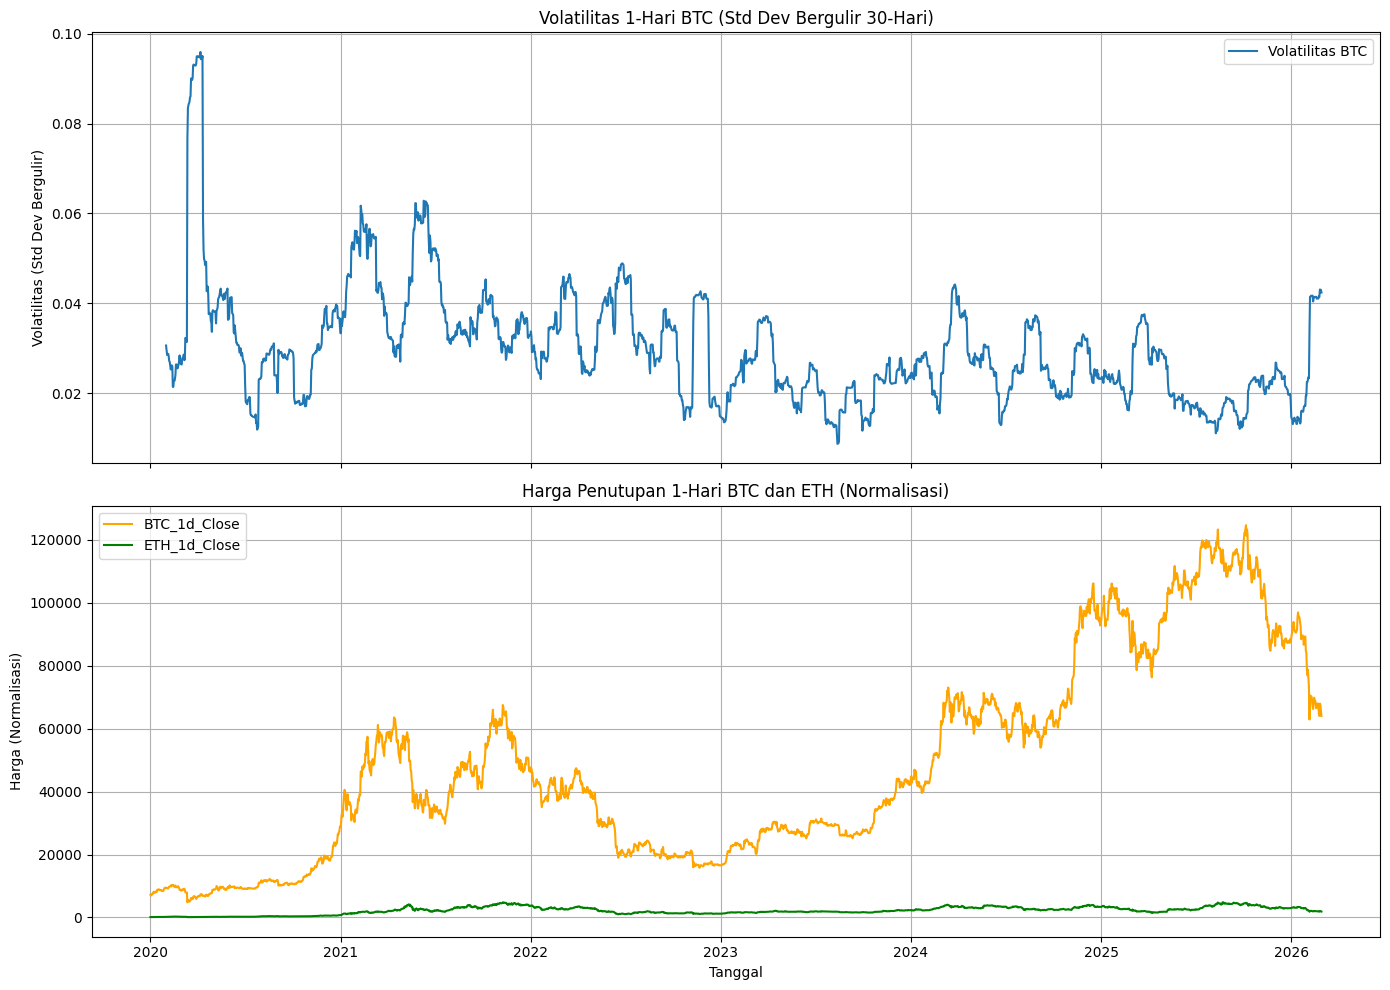

Plot untuk volatilitas BTC dan harga Penutupan 1-hari BTC/ETH telah dihasilkan.


In [3]:
# ==========================================================
# @title Plot Volatilitas BTC dan harga Penutupan 1-hari BTC/ETH
# ==========================================================

# 1. Ekstrak kolom 'BTC_1d_Close' dan 'ETH_1d_Close'
btc_close = data['BTC_1d_Close']
eth_close = data['ETH_1d_Close']

# 2. Hitung pengembalian harian untuk 'BTC_1d_Close'
btc_daily_returns = btc_close.pct_change()

# 3. Hitung standar deviasi bergulir (volatilitas) dari pengembalian harian BTC
# Gunakan jendela bergulir 30 hari.
btc_volatility = btc_daily_returns.rolling(window=30).std()

# 4. Buat gambar dengan dua subplot
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# 5. Plot volatilitas BTC yang dihitung pada subplot pertama
axes[0].plot(btc_volatility, label='Volatilitas BTC')
axes[0].set_title('Volatilitas 1-Hari BTC (Std Dev Bergulir 30-Hari)')
axes[0].set_ylabel('Volatilitas (Std Dev Bergulir)')
axes[0].legend()
axes[0].grid(True)

# 6. Plot 'BTC_1d_Close' dan 'ETH_1d_Close' pada subplot kedua
axes[1].plot(btc_close, label='BTC_1d_Close', color='orange')
axes[1].plot(eth_close, label='ETH_1d_Close', color='green')
axes[1].set_title('Harga Penutupan 1-Hari BTC dan ETH (Normalisasi)')
axes[1].set_ylabel('Harga (Normalisasi)')
axes[1].legend()
axes[1].grid(True)

# 7. Untuk kedua plot, beri label sumbu x sebagai 'Tanggal'
axes[1].set_xlabel('Tanggal')

# 8. Tampilkan plot
plt.tight_layout()
plt.show()

print("Plot untuk volatilitas BTC dan harga Penutupan 1-hari BTC/ETH telah dihasilkan.")

In [4]:
# ==========================================================
# @title Analisis Data
# ==========================================================
print(data.describe())

         BTC_1h_Open    BTC_1h_High     BTC_1h_Low   BTC_1h_Close  \
count    2251.000000    2251.000000    2251.000000    2251.000000   
mean    48022.902266   48226.170680   47804.884540   48021.143803   
std     31513.885339   31595.797057   31416.098661   31503.197176   
min      4811.800000    5053.200000    4460.000000    4646.600000   
25%     22624.250000   22805.150000   22475.750000   22600.250000   
50%     41018.900000   41367.900000   40793.400000   41190.200000   
75%     66672.000000   66855.450000   66446.950000   66592.450000   
max    124658.700000  124920.100000  124611.600000  124901.800000   

       BTC_1h_Volume  ETH_1h_Open  ETH_1h_High   ETH_1h_Low  ETH_1h_Close  \
count    2251.000000  2251.000000  2251.000000  2251.000000   2251.000000   
mean      230.412471  2172.462275  2185.975771  2158.331035   2172.479027   
std       268.519178  1167.843761  1174.467676  1160.681590   1167.793128   
min        10.046226   107.820000   112.000000   104.240000    107.170

# **DATA PREPARATION**

In [5]:
# ==========================================================
# @title Mengatur Hyperparameter untuk Model LSTM Multi-Coin Multi-Timeframe
# ==========================================================

# Hyperparameter disesuaikan untuk model LSTM yang lebih powerful
neurons = 1024                # Jumlah unit neuron di setiap layer LSTM (dinaikkan untuk kompleksitas lebih)
activation_function = 'tanh'  # Fungsi aktivasi untuk layer LSTM
loss = 'mse'                  # Fungsi kerugian (loss function) untuk regresi
optimizer = 'adam'            # Optimizer untuk melatih model
dropout = 0.4                 # Tingkat Dropout untuk regulasi (dinaikkan untuk model lebih besar)
batch_size = 64               # Ukuran batch untuk pelatihan model
epochs = 100                  # Jumlah epoch pelatihan (dinaikkan untuk pembelajaran lebih lanjut)
window_len = 24               # Panjang jendela waktu untuk input LSTM (misal: 24 jam/periode)
training_size = 0.8           # Proporsi data untuk training (misal: 80%)

In [6]:
# ==========================================================
# @title Pembersihan Data
# ==========================================================
print("Jumlah missing value sebelum drop:", data.isnull().sum().sum())

data = data.dropna()

print("Jumlah missing value setelah drop:", data.isnull().sum().sum())
print("Shape setelah cleaning:", data.shape)

Jumlah missing value sebelum drop: 0
Jumlah missing value setelah drop: 0
Shape setelah cleaning: (2251, 72)


In [7]:
# ==========================================================
# @title Feature Engineering (RSI, EMA, MACD)
# ==========================================================

print("Melakukan Feature Engineering (RSI, EMA, MACD)...")

# Indikator dihitung pada DataFrame 'data' yang sudah bersih (setelah dropna)
# dan belum diskalakan. Ini adalah urutan yang direkomendasikan.

coins = ['BTC', 'ETH', 'ADA', 'ALGO']
timeframes = ['1h', '4h', '1d']

for coin in coins:
    for tf in timeframes:
        print(f"  Menghitung indikator untuk {coin} {tf}...")
        prefix = f"{coin}_{tf}"
        close_col_name = f"{prefix}_Close"

        # Pastikan kolom Close ada dan numerik sebelum menghitung indikator
        # Operasikan langsung pada DataFrame 'data' yang sudah bersih.
        if close_col_name in data.columns and pd.api.types.is_numeric_dtype(data[close_col_name]):
            # Hitung RSI (Relative Strength Index)
            # Panjang default untuk RSI adalah 14
            data[f"{prefix}_RSI"] = ta.rsi(data[close_col_name], length=14)

            # Hitung EMA (Exponential Moving Average)
            # Menggunakan panjang umum seperti 20 untuk EMA
            data[f"{prefix}_EMA"] = ta.ema(data[close_col_name], length=20)

            # Hitung MACD (Moving Average Convergence Divergence)
            # Default cepat=12, lambat=26, sinyal=9
            macd_result = ta.macd(data[close_col_name], fast=12, slow=26, signal=9)

            if macd_result is not None and not macd_result.empty:
                # pandas_ta mengembalikan DataFrame dengan beberapa kolom terkait MACD
                # Tambahkan Garis MACD, Garis Sinyal MACD, dan Histogram MACD
                # Penugasan langsung ke 'data' akan bekerja karena indeks sejajar
                data[f"{prefix}_MACD_line"] = macd_result[f"MACD_{12}_{26}_{9}"]
                data[f"MACD_hist_{prefix}"] = macd_result[f"MACDh_{12}_{26}_{9}"]
                data[f"MACD_signal_{prefix}"] = macd_result[f"MACDs_{12}_{26}_{9}"]
            else:
                print(f"  Peringatan: Gagal menghitung MACD untuk {prefix}. Kolom mungkin tidak ada atau data tidak cukup.")
        else:
            print(f"  Peringatan: Kolom '{close_col_name}' tidak ditemukan atau bukan numerik. Melewatkan indikator untuk {coin} {tf}.")

# --- PENTING: Hapus baris dengan NaN yang muncul akibat perhitungan indikator ---
original_shape = data.shape
data = data.dropna()
print(f"Setelah feature engineering, {original_shape[0] - data.shape[0]} baris dengan NaN dihapus.")
# ---------------------------------------------------------------------------------

print("\nFeature Engineering (RSI, EMA, MACD) selesai.")
print("Shape data setelah feature engineering:", data.shape)
print("Contoh data terakhir setelah feature engineering (termasuk indikator baru):")
print(data.tail())

print("\nData kini telah diperbarui dengan fitur-fitur baru (RSI, EMA, MACD) dan dalam kondisi belum diskalakan.")

Melakukan Feature Engineering (RSI, EMA, MACD)...
  Menghitung indikator untuk BTC 1h...
  Menghitung indikator untuk BTC 4h...
  Menghitung indikator untuk BTC 1d...
  Menghitung indikator untuk ETH 1h...
  Menghitung indikator untuk ETH 4h...
  Menghitung indikator untuk ETH 1d...
  Menghitung indikator untuk ADA 1h...
  Menghitung indikator untuk ADA 4h...
  Menghitung indikator untuk ADA 1d...
  Menghitung indikator untuk ALGO 1h...
  Menghitung indikator untuk ALGO 4h...
  Menghitung indikator untuk ALGO 1d...
Setelah feature engineering, 33 baris dengan NaN dihapus.

Feature Engineering (RSI, EMA, MACD) selesai.
Shape data setelah feature engineering: (2218, 132)
Contoh data terakhir setelah feature engineering (termasuk indikator baru):
           BTC_1h_Date  BTC_1h_Open  BTC_1h_High  BTC_1h_Low  BTC_1h_Close  \
Date                                                                         
2026-02-24  2026-02-24      64656.1      65010.1     64656.0       64941.5   
2026-02-25  

/tmp/ipython-input-896/1450824755.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{prefix}_RSI"] = ta.rsi(data[close_col_name], length=14)
/tmp/ipython-input-896/1450824755.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{prefix}_EMA"] = ta.ema(data[close_col_name], length=20)
/tmp/ipython-input-896/1450824755.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

In [8]:
# ==========================================================
# @title Normalisasi Data
# ==========================================================

# Memilih hanya kolom numerik untuk scaling
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()

# Inisialisasi MinMaxScaler
# Menggunakan scaler baru agar tidak bentrok dengan scaler yang digunakan untuk model LSTM
scaler_data_frame = MinMaxScaler(feature_range=(0, 1))

# Terapkan scaling pada kolom numerik di DataFrame 'data'
data[numerical_cols] = scaler_data_frame.fit_transform(data[numerical_cols])

print("Data numerik di DataFrame 'data' telah berhasil dinormalisasi.")
print("Contoh data setelah normalisasi (5 baris terakhir):")
print(data[numerical_cols].tail())

Data numerik di DataFrame 'data' telah berhasil dinormalisasi.
Contoh data setelah normalisasi (5 baris terakhir):
            BTC_1h_Open  BTC_1h_High  BTC_1h_Low  BTC_1h_Close  BTC_1h_Volume  \
Date                                                                            
2026-02-24     0.499340     0.500196    0.501000      0.501391       0.023227   
2026-02-25     0.494330     0.494413    0.494819      0.495416       0.030585   
2026-02-26     0.527120     0.529577    0.526617      0.529639       0.068382   
2026-02-27     0.522945     0.521274    0.520534      0.520373       0.038544   
2026-02-28     0.509488     0.508562    0.509932      0.509712       0.028432   

            ETH_1h_Open  ETH_1h_High  ETH_1h_Low  ETH_1h_Close  ETH_1h_Volume  \
Date                                                                            
2026-02-24     0.370319     0.372487    0.372797      0.374636       0.060300   
2026-02-25     0.369360     0.369782    0.370968      0.371250       0.041

In [9]:
# ==========================================================
# @title Pembuatan Time Series Windowing untuk LSTM
# ==========================================================

print("Membuat windowing time series data...")

# Pilih fitur-fitur yang akan digunakan sebagai input untuk LSTM
# Kita akan menggunakan semua kolom numerik yang ada di DataFrame 'data' sebagai fitur input
# Kolom target (y) akan menjadi harga 'Close' BTC pada timeframe 4 jam

# Memastikan kolom Date di-drop sebelum mengambil semua kolom numerik untuk fitur
# karena kita tidak ingin Date menjadi bagian dari fitur numerik untuk model
feature_cols = data.select_dtypes(include=np.number).columns.tolist()

# Pisahkan data menjadi training dan testing set
train_size = int(len(data) * training_size)
train_data = data[feature_cols].iloc[:train_size]
test_data = data[feature_cols].iloc[train_size:]

print(f"Ukuran data training: {len(train_data)}")
print(f"Ukuran data testing: {len(test_data)}")

# Fungsi untuk membuat sequence input (X) dan output (y) untuk LSTM
# y akan menjadi harga Close BTC_4h berikutnya
def create_sequences(dataset, window_len):
    X, y = [], []
    # Menemukan indeks kolom target 'BTC_1h_Close'
    try:
        btc_close_idx = dataset.columns.get_loc('BTC_1h_Close')
    except KeyError:
        print("Kolom 'BTC_1h_Close' tidak ditemukan. Harap pastikan nama kolom sudah benar.")
        return np.array([]), np.array([])

    for i in range(window_len, len(dataset)):
        X.append(dataset.iloc[i-window_len:i].values) # window_len periode sebelumnya sebagai input
        y.append(dataset.iloc[i, btc_close_idx])     # Harga Close BTC_4h pada periode saat ini sebagai target
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, window_len)
X_test, y_test = create_sequences(test_data, window_len)

# Cek shape data sebelum reshape (untuk debugging jika diperlukan)
print("Shape X_train sebelum reshape:", X_train.shape)
print("Shape X_test sebelum reshape:", X_test.shape)

# Reshape X untuk input LSTM: (samples, timesteps, features)
# Timesteps adalah window_len
# Features adalah jumlah kolom fitur yang dipilih
if X_train.size > 0:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
else:
    print("X_train kosong, periksa data.")

if X_test.size > 0:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
else:
    print("X_test kosong, periksa data.")

print("Shape X_train (LSTM input):")
print(X_train.shape)
print("Shape y_train:")
print(y_train.shape)
print("Shape X_test (LSTM input):")
print(X_test.shape)
print("Shape y_test:")
print(y_test.shape)

print("Windowing time series data selesai.")

Membuat windowing time series data...
Ukuran data training: 1774
Ukuran data testing: 444
Shape X_train sebelum reshape: (1750, 24, 120)
Shape X_test sebelum reshape: (420, 24, 120)
Shape X_train (LSTM input):
(1750, 24, 120)
Shape y_train:
(1750,)
Shape X_test (LSTM input):
(420, 24, 120)
Shape y_test:
(420,)
Windowing time series data selesai.


# **Modeling**

In [10]:
# ==========================================================
# @title Membangun dan Compile Model LSTM Multi-Coin Multi-Timeframe
# ==========================================================

# Membangun model LSTM dengan hyperparameter yang disesuaikan untuk data multi-coin multi-timeframe
model = Sequential()

# Layer LSTM pertama dengan return_sequences=True untuk pass ke layer berikutnya
model.add(LSTM(units=neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation=activation_function))
model.add(Dropout(dropout))  # Dropout untuk hindari overfitting

# Layer LSTM kedua
model.add(LSTM(units=neurons, return_sequences=True, activation=activation_function))
model.add(Dropout(dropout))

# Layer LSTM ketiga
model.add(LSTM(units=neurons, return_sequences=True, activation=activation_function)) # Layer tambahan
model.add(Dropout(dropout))

# Layer LSTM keempat (terakhir, tanpa return_sequences)
model.add(LSTM(units=neurons, activation=activation_function))
model.add(Dropout(dropout))

# Layer output Dense untuk regresi harga BTC
model.add(Dense(units=1))  # 1 output untuk prediksi harga Close BTC

# Compile model dengan loss, optimizer, dan metrics MAE
model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

# Tampilkan ringkasan model
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 1024)       │     4,689,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 1024)       │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 1024)       │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1024)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,869,057 (113.94 MB)

 Trainable params: 29,869,057 (113.94 MB)

 Non-trainable params: 0 (0.00 B)

Memulai pelatihan model LSTM...
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 4.4977 - mae: 1.0800 
Epoch 1: val_loss improved from inf to 0.29972, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 359ms/step - loss: 4.4007 - mae: 1.0627 - val_loss: 0.2997 - val_mae: 0.5396
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0224 - mae: 0.1093
Epoch 2: val_loss improved from 0.29972 to 0.11566, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step - loss: 0.0222 - mae: 0.1088 - val_loss: 0.1157 - val_mae: 0.3312
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0081 - mae: 0.0682
Epoch 3: val_loss improved from 0.11566 to 0.04387, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.0080 - mae: 0.0680 - val_loss: 0.0439 - val_mae: 0.1982
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0042 - mae: 0.0499 
Epoch 4: val_loss improved from 0.04387 to 0.02563, saving model to

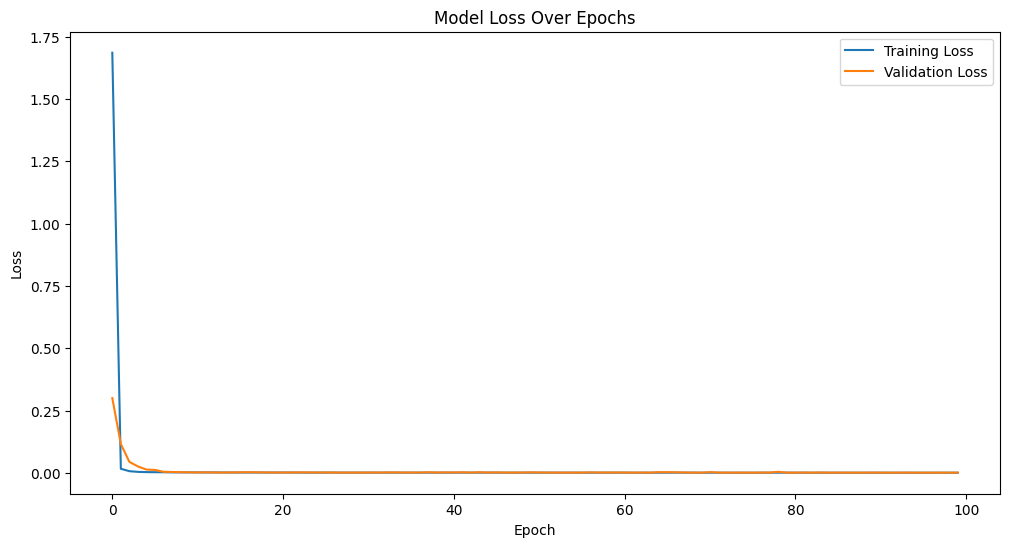

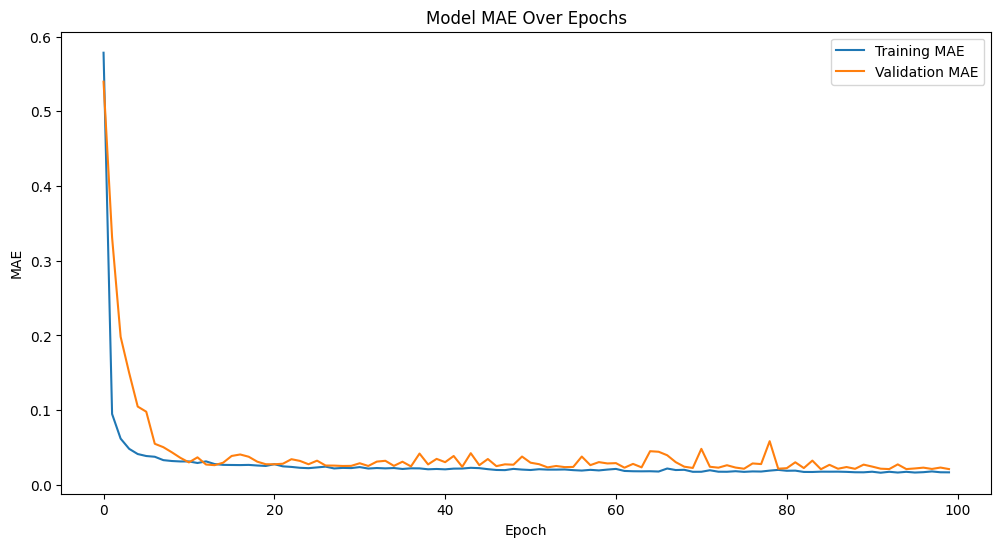

In [11]:
# ==========================================================
# @title Pelatihan Model LSTM
# ==========================================================

print("Memulai pelatihan model LSTM...")

# Impor ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

# Definisikan path untuk menyimpan model terbaik
filepath = 'best_model.keras'
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

callbacks_list = [checkpoint]

# Memulai pelatihan model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list, # Tambahkan callbacks di sini
    verbose=1
)

print("Pelatihan model selesai.")

# Plot history pelatihan
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# **Model Evaluation**

In [12]:
# ==========================================================
# @title Evaluasi Model
# ==========================================================

print("Membuat prediksi pada data testing...")

# Memuat model terbaik yang telah disimpan
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

# Membuat prediksi
predictions = model.predict(X_test)

# Karena target (y_test) adalah 'BTC_1h_Close' yang sudah diskalakan,
# prediksi juga akan dalam skala 0-1. Kita perlu mendiskalakan kembali
# y_test dan predictions ke skala aslinya untuk interpretasi yang lebih mudah.

# Untuk mendiskalakan, kita butuh scaler yang digunakan untuk 'BTC_1h_Close'.
# Karena kita menormalisasi seluruh DataFrame 'data' secara sekaligus,
# scaler_data_frame memiliki min/max untuk semua kolom.
# Kita perlu tahu kolom mana yang digunakan sebagai target (BTC_1h_Close)
# dan menggunakan min/max dari kolom tersebut untuk diskala.

# Mengambil kolom 'BTC_1h_Close' dari DataFrame 'data' yang sudah dinormalisasi
# dan menemukan indeksnya.
# Ini penting karena scaler_data_frame.inverse_transform membutuhkan array 2D
# dengan jumlah fitur yang sama dengan yang di-fit.
# Cara paling aman adalah membuat dummy array dengan 0 di semua fitur kecuali target
# lalu melakukan inverse transform.

# Dapatkan feature_cols lagi (seperti di create_sequences)
feature_cols = data.select_dtypes(include=np.number).columns.tolist()
btc_close_idx = feature_cols.index('BTC_1h_Close')

# Buat array dummy dengan shape yang sesuai untuk inverse_transform
dummy_array_for_inverse = np.zeros((len(y_test), len(feature_cols)))

# Masukkan nilai y_test yang diskalakan ke posisi kolom target
dummy_array_for_inverse[:, btc_close_idx] = y_test

y_test_descaled = scaler_data_frame.inverse_transform(dummy_array_for_inverse)[:, btc_close_idx]

# Ulangi proses untuk prediksi
dummy_array_for_inverse_pred = np.zeros((len(predictions), len(feature_cols)))
dummy_array_for_inverse_pred[:, btc_close_idx] = predictions.flatten()

predictions_descaled = scaler_data_frame.inverse_transform(dummy_array_for_inverse_pred)[:, btc_close_idx]

print("Evaluasi Model...")

# Menghitung Metrik Evaluasi
mae = mean_absolute_error(y_test_descaled, predictions_descaled)
rmse = root_mean_squared_error(y_test_descaled, predictions_descaled)
mape = mean_absolute_percentage_error(y_test_descaled, predictions_descaled) * 100 # dalam persentase

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

print("Evaluasi model selesai.")

Membuat prediksi pada data testing...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Evaluasi Model...
Mean Absolute Error (MAE): 2517.3408
Root Mean Squared Error (RMSE): 3242.2835
Mean Absolute Percentage Error (MAPE): 2.62%
Evaluasi model selesai.


Visualisasi Hasil Prediksi...


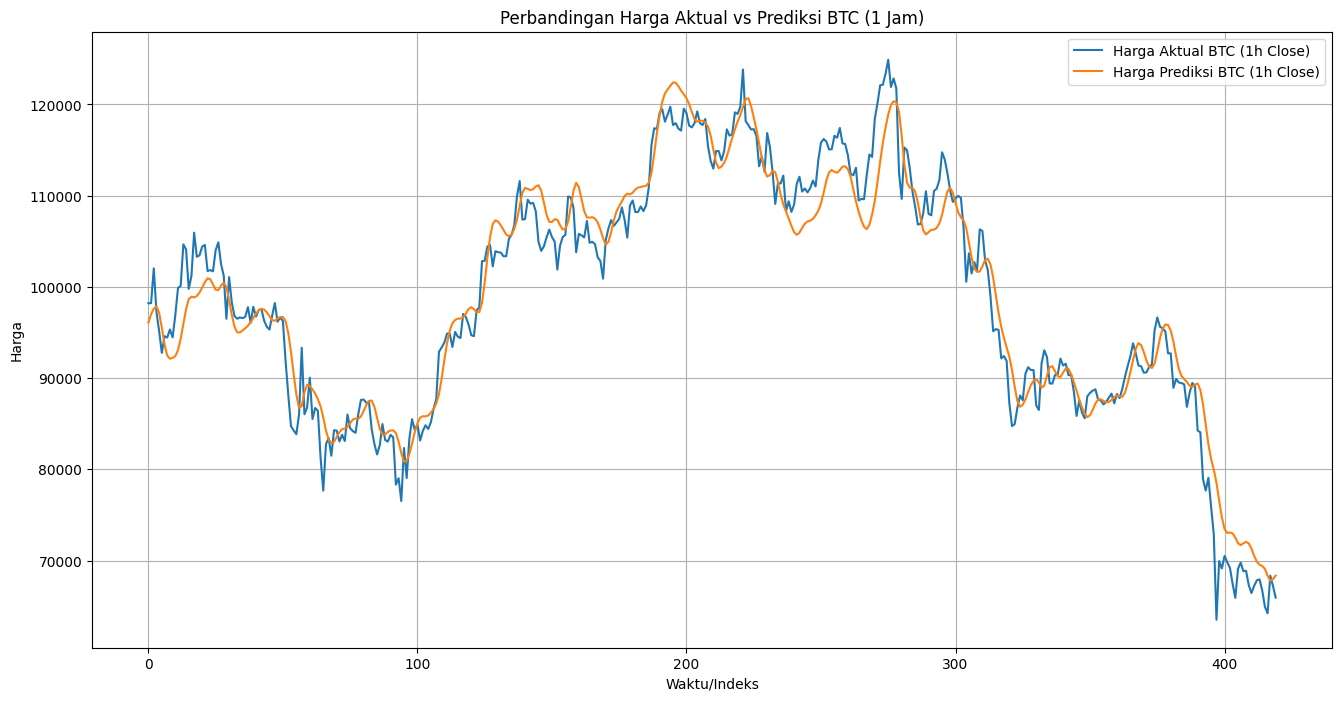

In [13]:
# ==========================================================
# @title Visualisasi Hasil Prediksi
# ==========================================================

print("Visualisasi Hasil Prediksi...")

# Visualisasi Hasil Prediksi
plt.figure(figsize=(16, 8))
plt.plot(y_test_descaled, label='Harga Aktual BTC (1h Close)')
plt.plot(predictions_descaled, label='Harga Prediksi BTC (1h Close)')
plt.title('Perbandingan Harga Aktual vs Prediksi BTC (1 Jam)')
plt.xlabel('Waktu/Indeks')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
print("Mendefinisikan aturan trading berbasis prediksi LSTM...")

# 1. Get the dates corresponding to y_test_descaled and predictions_descaled
# The original 'data' DataFrame has 'Date' as its index.
# We need to slice the index from where test data started (train_size) plus window_len
# because the sequences start after window_len.
test_dates = data.index[train_size + window_len:]

# 2. Create a new Pandas DataFrame named lstm_strategy_data
lstm_strategy_data = pd.DataFrame({
    'Actual_Price': y_test_descaled,
    'Predicted_Price': predictions_descaled.flatten() # Ensure predictions are 1D
}, index=test_dates)

# 3. Define a buy_threshold
buy_threshold = 0.005  # 0.5% predicted price increase to generate a buy signal

# 4. Create a new column 'Buy_Signal'
# A 'Buy_Signal' is generated if Predicted_Price is significantly higher than Actual_Price
lstm_strategy_data['Buy_Signal'] = (lstm_strategy_data['Predicted_Price'] > lstm_strategy_data['Actual_Price'] * (1 + buy_threshold)).astype(int)

# Tambahkan kolom 'Sell_Signal' secara eksplisit
lstm_strategy_data['Sell_Signal'] = (lstm_strategy_data['Predicted_Price'] <= lstm_strategy_data['Actual_Price']).astype(int)

# 5. Initialize additional columns for trading simulation
lstm_strategy_data['Position'] = 0 # 0: no position, 1: long position
lstm_strategy_data['Entry_Price'] = np.nan
lstm_strategy_data['Buy_Trade'] = 0
lstm_strategy_data['Sell_Trade'] = 0

print("Aturan trading berbasis prediksi LSTM telah didefinisikan.")
print("Contoh data strategi (5 baris pertama):")
print(lstm_strategy_data.head())

Mendefinisikan aturan trading berbasis prediksi LSTM...
Aturan trading berbasis prediksi LSTM telah didefinisikan.
Contoh data strategi (5 baris pertama):
            Actual_Price  Predicted_Price  Buy_Signal  Sell_Signal  Position  \
Date                                                                           
2025-01-05       98216.6     96101.283355           0            1         0   
2025-01-06       98210.9     96992.409004           0            1         0   
2025-01-07      102035.7     97613.058909           0            1         0   
2025-01-08       97263.4     97859.114065           1            0         0   
2025-01-09       95135.2     97145.118311           1            0         0   

            Entry_Price  Buy_Trade  Sell_Trade  
Date                                            
2025-01-05          NaN          0           0  
2025-01-06          NaN          0           0  
2025-01-07          NaN          0           0  
2025-01-08          NaN          0     

In [33]:
print("\nMelakukan simulasi perdagangan dengan sinyal BELI berbasis LSTM...")

initial_cash = 100000  # Modal awal
current_cash = initial_cash
position = 0           # 0: tidak ada posisi, 1: posisi beli
entry_price = 0        # Harga saat masuk posisi
shares = 0             # Jumlah saham/unit crypto yang dibeli
lstm_trade_records = []    # Menyimpan detail setiap perdagangan
lstm_equity_data = [{'Date': lstm_strategy_data.index[0], 'Cash': initial_cash}] # Untuk kurva ekuitas


# Fungsi untuk menghitung profit/loss percentage
def calculate_profit_loss(entry, exit):
    return ((exit - entry) / entry) * 100

for i in range(len(lstm_strategy_data)):
    current_date = lstm_strategy_data.index[i]
    actual_price = lstm_strategy_data['Actual_Price'].iloc[i]
    predicted_price = lstm_strategy_data['Predicted_Price'].iloc[i]
    buy_signal = lstm_strategy_data['Buy_Signal'].iloc[i]

    # Cek sinyal BELI
    if buy_signal == 1 and position == 0:
        # Masuk posisi
        entry_price = actual_price
        shares = current_cash / entry_price # Beli sebanyak mungkin
        position = 1
        lstm_strategy_data.loc[current_date, 'Position'] = 1
        lstm_strategy_data.loc[current_date, 'Entry_Price'] = entry_price
        lstm_strategy_data.loc[current_date, 'Buy_Trade'] = 1 # Mark as actual buy trade
        # print(f"Beli pada {current_date}: Harga {entry_price:.2f}")

    # Cek sinyal JUAL (jika ada posisi)
    # Exit jika predicted price drops below actual price (or not significantly above)
    # This acts as a simple dynamic exit.
    if position == 1:
        # The exit condition is that the predicted price is no longer significantly higher than actual price.
        # Reusing the buy_threshold logic for exit to simplify: if the predicted price is not above (actual_price * (1 + buy_threshold)), then exit.
        # Or, a simpler exit: if predicted_price <= actual_price, then exit.
        if predicted_price <= actual_price: # If prediction is no longer bullish
            exit_price = actual_price
            profit_loss_percent = calculate_profit_loss(entry_price, exit_price)
            current_cash = shares * exit_price
            lstm_trade_records.append({
                'Entry_Date': lstm_strategy_data.loc[lstm_strategy_data['Entry_Price'] == entry_price].index[0] if not lstm_strategy_data.loc[lstm_strategy_data['Entry_Price'] == entry_price].empty else current_date,
                'Entry_Price': entry_price,
                'Exit_Date': current_date,
                'Exit_Price': exit_price,
                'Profit_Loss_Percentage': profit_loss_percent,
                'Cash_After_Trade': current_cash
            })
            lstm_strategy_data.loc[current_date, 'Position'] = 0
            lstm_strategy_data.loc[current_date, 'Sell_Trade'] = 1 # Mark as actual sell trade
            position = 0
            entry_price = 0
            shares = 0
            # print(f"Jual pada {current_date}: Harga {exit_price:.2f}, P/L: {profit_loss_percent:.2f}%")

    # Update equity curve (if holding, update with current market value)
    if position == 1:
        lstm_equity_data.append({'Date': current_date, 'Cash': shares * actual_price})
    else:
        lstm_equity_data.append({'Date': current_date, 'Cash': current_cash})


# Jika ada posisi yang masih terbuka di akhir data, tutup secara paksa
if position == 1:
    exit_price = lstm_strategy_data['Actual_Price'].iloc[-1]
    profit_loss_percent = calculate_profit_loss(entry_price, exit_price)
    current_cash = shares * exit_price
    # The Entry_Date for the last open trade might be hard to get if there are multiple entries with same price
    # Simplification: get the first instance of the entry price or use the current_date if not found (shouldn't happen with unique Entry_Prices typically)
    entry_date_last_trade = lstm_strategy_data.loc[lstm_strategy_data['Entry_Price'] == entry_price].index[0] if entry_price != 0 and not lstm_strategy_data.loc[lstm_strategy_data['Entry_Price'] == entry_price].empty else lstm_strategy_data.index[-1]
    lstm_trade_records.append({
        'Entry_Date': entry_date_last_trade,
        'Entry_Price': entry_price,
        'Exit_Date': lstm_strategy_data.index[-1],
        'Exit_Price': exit_price,
        'Profit_Loss_Percentage': profit_loss_percent,
        'Cash_After_Trade': current_cash
    })
    lstm_strategy_data.loc[lstm_strategy_data.index[-1], 'Position'] = 0
    lstm_strategy_data.loc[lstm_strategy_data.index[-1], 'Sell_Trade'] = 1 # Mark as actual sell trade
    # print(f"Menutup posisi akhir pada {lstm_strategy_data.index[-1]}: Harga {exit_price:.2f}, P/L: {profit_loss_percent:.2f}%")

# Convert trade records and equity data to DataFrame
lstm_trade_records_df = pd.DataFrame(lstm_trade_records)
lstm_equity_curve = pd.DataFrame(lstm_equity_data).set_index('Date')
lstm_equity_curve.index = pd.to_datetime(lstm_equity_curve.index)

print("\nSimulasi perdagangan selesai.")
print(f"Modal akhir: {current_cash:.2f}")
if not lstm_trade_records_df.empty:
    print("\nCatatan Perdagangan (5 transaksi terakhir):")
    print(lstm_trade_records_df.tail())
else:
    print("\nTidak ada transaksi yang tercatat.")

print("\nKurva Ekuitas (5 baris terakhir):")
print(lstm_equity_curve.tail())


Melakukan simulasi perdagangan dengan sinyal BELI berbasis LSTM...

Simulasi perdagangan selesai.
Modal akhir: 94924.54

Catatan Perdagangan (5 transaksi terakhir):
   Entry_Date  Entry_Price  Exit_Date  Exit_Price  Profit_Loss_Percentage  \
31 2025-12-30      87241.0 2025-12-31     88256.2                1.163673   
32 2026-01-07      92703.9 2026-01-13     91490.0               -1.309438   
33 2026-01-18      95116.1 2026-01-28     89467.7               -5.938427   
34 2026-01-30      84251.6 2026-02-26     68338.4              -18.887713   
35 2026-02-27      67224.1 2026-02-28     65942.1               -1.907054   

    Cash_After_Trade  
31     128518.664722  
32     126835.792619  
33     119303.741883  
34      96769.994093  
35      94924.537888  

Kurva Ekuitas (5 baris terakhir):
                    Cash
Date                    
2026-02-24  91959.843534
2026-02-25  90942.417888
2026-02-26  96769.994093
2026-02-27  96769.994093
2026-02-28  94924.537888



Memvisualisasikan kinerja strategi BELI berbasis LSTM...


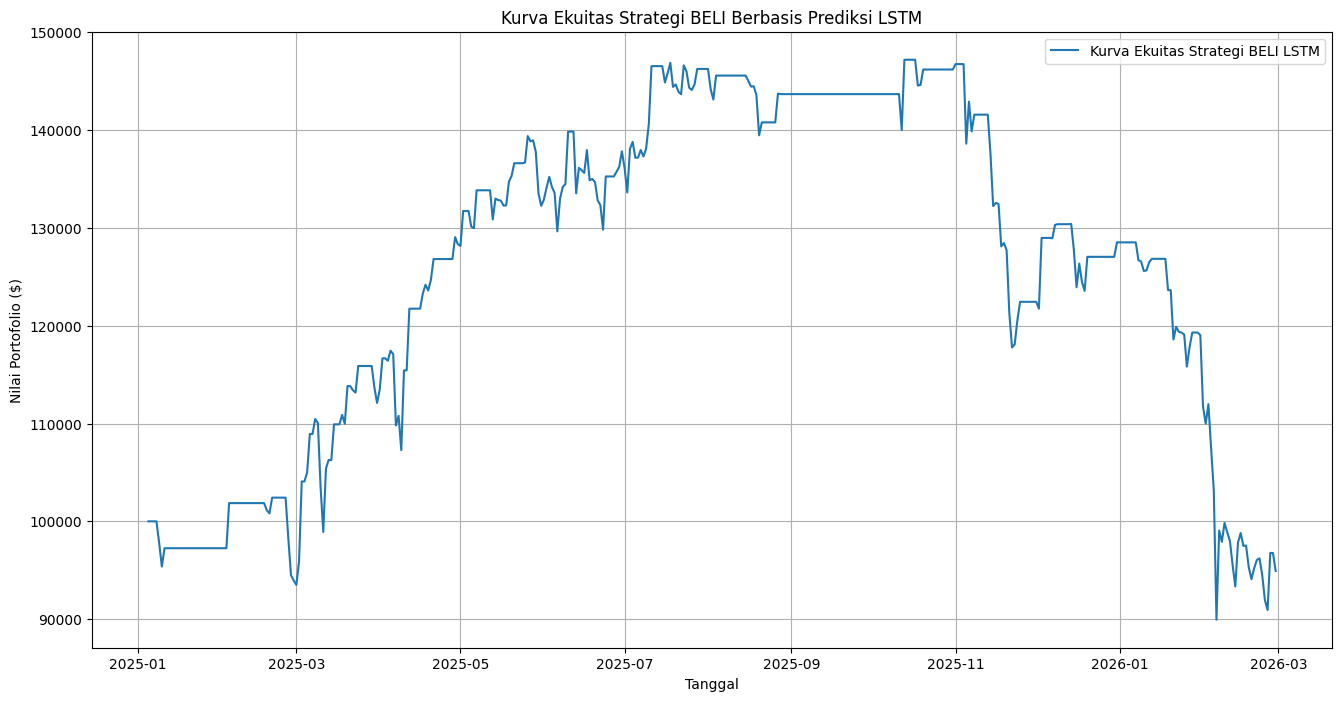

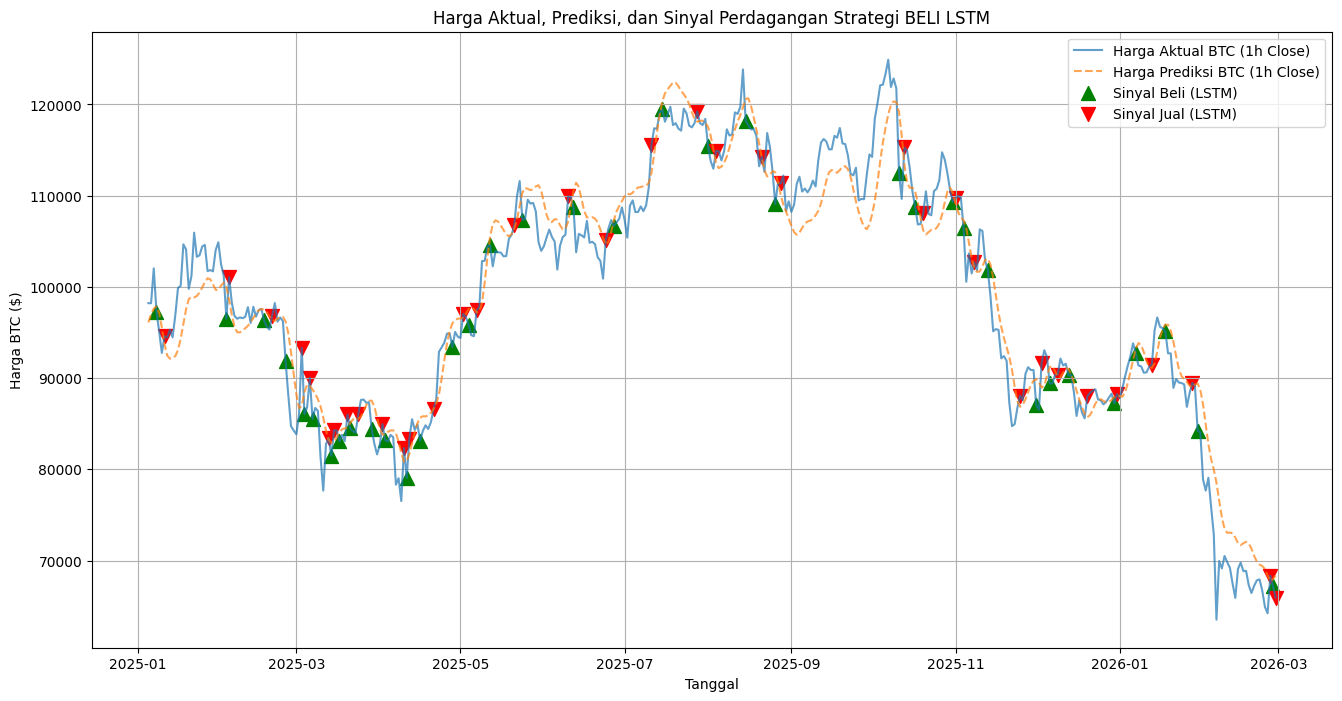


Visualisasi kinerja strategi BELI berbasis LSTM selesai.


In [34]:
print("\nMemvisualisasikan kinerja strategi BELI berbasis LSTM...")

# Plot kurva ekuitas
plt.figure(figsize=(16, 8))
plt.plot(lstm_equity_curve['Cash'], label='Kurva Ekuitas Strategi BELI LSTM')
plt.title('Kurva Ekuitas Strategi BELI Berbasis Prediksi LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Portofolio ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot harga aktual, harga prediksi, dan sinyal beli/jual
plt.figure(figsize=(16, 8))
plt.plot(lstm_strategy_data['Actual_Price'], label='Harga Aktual BTC (1h Close)', alpha=0.7)
plt.plot(lstm_strategy_data['Predicted_Price'], label='Harga Prediksi BTC (1h Close)', alpha=0.7, linestyle='--')

# Plot sinyal beli
buy_signals = lstm_strategy_data[lstm_strategy_data['Buy_Trade'] == 1]
plt.scatter(buy_signals.index, buy_signals['Actual_Price'], marker='^', color='green', s=100, label='Sinyal Beli (LSTM)')

# Plot sinyal jual (jika ada)
sell_signals = lstm_strategy_data[lstm_strategy_data['Sell_Trade'] == 1]
plt.scatter(sell_signals.index, sell_signals['Actual_Price'], marker='v', color='red', s=100, label='Sinyal Jual (LSTM)')


plt.title('Harga Aktual, Prediksi, dan Sinyal Perdagangan Strategi BELI LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Harga BTC ($)')
plt.legend()
plt.grid(True)
plt.show()

print("\nVisualisasi kinerja strategi BELI berbasis LSTM selesai.")

In [35]:
print("\nMenghitung metrik backtesting untuk strategi BELI berbasis LSTM...")

if not lstm_trade_records_df.empty:
    # Total Return
    lstm_total_return = ((current_cash - initial_cash) / initial_cash) * 100
    print(f"Total Return: {lstm_total_return:.2f}%")

    # Win Rate
    lstm_profitable_trades = lstm_trade_records_df[lstm_trade_records_df['Profit_Loss_Percentage'] > 0]
    lstm_win_rate = (len(lstm_profitable_trades) / len(lstm_trade_records_df)) * 100
    print(f"Win Rate: {lstm_win_rate:.2f}%")

    # Maximum Drawdown
    # Calculate daily returns for the equity curve
    lstm_daily_returns = lstm_equity_curve['Cash'].pct_change()
    lstm_roll_max = lstm_equity_curve['Cash'].expanding().max()
    lstm_drawdown = (lstm_equity_curve['Cash'] / lstm_roll_max) - 1.0
    lstm_max_drawdown = lstm_drawdown.min() * 100 # In percentage
    abs_lstm_max_drawdown_val = lstm_max_drawdown # Keep as negative percentage
    print(f"Maximum Drawdown: {abs_lstm_max_drawdown_val:.2f}%")


    # Sharpe Ratio
    # Asumsi risk_free_rate = 0 untuk kemudahan, atau bisa gunakan tingkat bunga bank sentral
    risk_free_rate = 0 # Bisa disesuaikan
    lstm_avg_daily_return = lstm_daily_returns.mean()
    lstm_std_daily_return = lstm_daily_returns.std()

    if lstm_std_daily_return != 0:
        # Annualisasi Sharpe Ratio. Faktor annualisasi tergantung timeframe data.
        # Untuk data 1 jam (1h), ada 24 * 365 = 8760 periode per tahun.
        annualization_factor = np.sqrt(24 * 365) # For 1-hour data
        lstm_sharpe_ratio = (lstm_avg_daily_return - (risk_free_rate / annualization_factor)) / lstm_std_daily_return * annualization_factor
        print(f"Sharpe Ratio: {lstm_sharpe_ratio:.2f}")
    else:
        lstm_sharpe_ratio = np.nan
        print("Sharpe Ratio: Tidak dapat dihitung (deviasi standar nol).")

else:
    print("Tidak ada transaksi yang dilakukan, metrik tidak dapat dihitung.")

print("\nPenghitungan metrik backtesting selesai.")


Menghitung metrik backtesting untuk strategi BELI berbasis LSTM...
Total Return: -5.08%
Win Rate: 58.33%
Maximum Drawdown: -38.89%
Sharpe Ratio: 0.21

Penghitungan metrik backtesting selesai.


In [36]:
# ==========================================================
# @title Mengonversi y_test_descaled menjadi Pandas Series
# ==========================================================

print("Mengonversi y_test_descaled menjadi Pandas Series...")

# Convert y_test_descaled to a Pandas Series with the appropriate index
# The test_dates was computed in the N-step-ahead prediction cell.
# We need to re-compute it or ensure it's available.
# For simplicity, we will re-derive it here based on y_test_descaled length.

# Ensure 'data' DataFrame is available and has an index
if 'data' not in globals() or data.empty:
    raise ValueError("DataFrame 'data' tidak ditemukan atau kosong. Pastikan langkah pengumpulan data telah dijalankan.")

# Assuming y_test_descaled corresponds to the last part of the 'data' DataFrame
# The index length for y_test_descaled should match the number of samples in y_test_descaled
# which starts after the training_size and window_len offset.

# Re-create test_dates index from the original 'data' DataFrame
train_size = int(len(data) * training_size) # Re-get training_size if not global
# The y_test corresponds to data from index (train_size + window_len) onwards in the original 'data' index
actual_prices_series_index = data.index[train_size + window_len:]

# Adjust length if mismatch (e.g., due to previous dropna in feature engineering)
min_len = min(len(y_test_descaled), len(actual_prices_series_index))
actual_prices_series_index = actual_prices_series_index[:min_len]
y_test_descaled_trimmed = y_test_descaled[:min_len]

actual_prices_series = pd.Series(y_test_descaled_trimmed, index=actual_prices_series_index)

print("Pandas Series 'actual_prices_series' telah dibuat.")
print(actual_prices_series.head())

Mengonversi y_test_descaled menjadi Pandas Series...
Pandas Series 'actual_prices_series' telah dibuat.
Date
2025-01-05     98216.6
2025-01-06     98210.9
2025-01-07    102035.7
2025-01-08     97263.4
2025-01-09     95135.2
dtype: float64


In [37]:
print("Menghitung arah pergerakan harga aktual...")

# 1. Convert y_test_descaled to a Pandas Series with the appropriate index
# This step is now handled by cell 4b39f1f2, ensuring actual_prices_series is defined.
# If actual_prices_series is not yet defined, run the previous cell first.
if 'actual_prices_series' not in globals():
    raise NameError("'actual_prices_series' belum didefinisikan. Jalankan sel sebelumnya.")

# 2. Calculate the daily percentage change
actual_percentage_change = actual_prices_series.pct_change()

# 3. Create a new Series 'actual_directions'
# 1 for up, -1 for down, 0 for no change
actual_directions = np.sign(actual_percentage_change)

print("Arah pergerakan harga aktual telah dihitung.")
print(actual_directions.head())

Menghitung arah pergerakan harga aktual...
Arah pergerakan harga aktual telah dihitung.
Date
2025-01-05    NaN
2025-01-06   -1.0
2025-01-07    1.0
2025-01-08   -1.0
2025-01-09   -1.0
dtype: float64


In [38]:
print("Menghitung arah pergerakan harga prediksi...")

# 1. Convert predictions_descaled to a Pandas Series with the appropriate index
predicted_prices_series = pd.Series(predictions_descaled.flatten(), index=lstm_strategy_data.index)

# 2. Calculate the daily percentage change for predicted prices
predicted_percentage_change = predicted_prices_series.pct_change()

# 3. Create a new Series 'predicted_directions'
# 1 for up, -1 for down, 0 for no change
predicted_directions = np.sign(predicted_percentage_change)

print("Arah pergerakan harga prediksi telah dihitung.")
print(predicted_directions.head())

Menghitung arah pergerakan harga prediksi...
Arah pergerakan harga prediksi telah dihitung.
Date
2025-01-05    NaN
2025-01-06    1.0
2025-01-07    1.0
2025-01-08    1.0
2025-01-09   -1.0
dtype: float64


In [40]:
print("Menghitung akurasi arah pergerakan harga...")

# Ensure all necessary series are defined
if 'predicted_directions' not in globals():
    raise NameError("'predicted_directions' belum didefinisikan. Jalankan sel 'Menghitung arah pergerakan harga prediksi...' terlebih dahulu.")
if 'actual_directions' not in globals():
    raise NameError("'actual_directions' belum didefinisikan. Jalankan sel 'Menghitung arah pergerakan harga aktual...' terlebih dahulu.")

# Hapus baris pertama (NaN) karena pct_change() menghasilkan NaN untuk entri pertama
actual_directions_cleaned = actual_directions.dropna()
predicted_directions_cleaned = predicted_directions.dropna()

# Pastikan indeks selaras setelah dropna
common_index = actual_directions_cleaned.index.intersection(predicted_directions_cleaned.index)
actual_directions_aligned = actual_directions_cleaned.loc[common_index]
predicted_directions_aligned = predicted_directions_cleaned.loc[common_index]

# Bandingkan arah yang diprediksi dengan arah aktual
# Cocokkan jika arahnya sama (1==1 atau -1==-1)
matches = (actual_directions_aligned == predicted_directions_aligned)

# Calculate directional accuracy
if len(matches) > 0:
    directional_accuracy = (matches.sum() / len(matches)) * 100
    print(f"Akurasi Arah (Directional Accuracy): {directional_accuracy:.2f}%")
else:
    directional_accuracy = 0.0
    print("Tidak ada data yang cocok untuk menghitung akurasi arah.")

# Tambahkan ke DataFrame lstm_strategy_data untuk visualisasi
# Ensure lstm_strategy_data is available, otherwise create a dummy or raise error
if 'lstm_strategy_data' not in globals():
    print("Peringatan: 'lstm_strategy_data' tidak ditemukan. Membuat DataFrame baru untuk visualisasi arah.")
    # If lstm_strategy_data is not available, create a temporary one for directional visualization
    # The index used here must be aligned with actual_directions_aligned and predicted_directions_aligned
    lstm_strategy_data = pd.DataFrame(index=common_index)
    lstm_strategy_data['Actual_Price'] = actual_prices_series.loc[common_index] # Assuming actual_prices_series is available
    lstm_strategy_data['Predicted_Price'] = predicted_prices_series.loc[common_index] # Assuming predicted_prices_series is available

# Assign directions and match to lstm_strategy_data, ensuring index alignment
lstm_strategy_data.loc[common_index, 'Actual_Direction'] = actual_directions_aligned
lstm_strategy_data.loc[common_index, 'Predicted_Direction'] = predicted_directions_aligned
lstm_strategy_data.loc[common_index, 'Direction_Match'] = matches.astype(int)

print("Akurasi arah pergerakan harga telah dihitung dan ditambahkan ke DataFrame.")
print(lstm_strategy_data[['Actual_Direction', 'Predicted_Direction', 'Direction_Match']].head())

Menghitung akurasi arah pergerakan harga...
Akurasi Arah (Directional Accuracy): 54.65%
Akurasi arah pergerakan harga telah dihitung dan ditambahkan ke DataFrame.
            Actual_Direction  Predicted_Direction  Direction_Match
Date                                                              
2025-01-05               NaN                  NaN              NaN
2025-01-06              -1.0                  1.0              0.0
2025-01-07               1.0                  1.0              1.0
2025-01-08              -1.0                  1.0              0.0
2025-01-09              -1.0                 -1.0              1.0


Memvisualisasikan akurasi arah pergerakan harga...


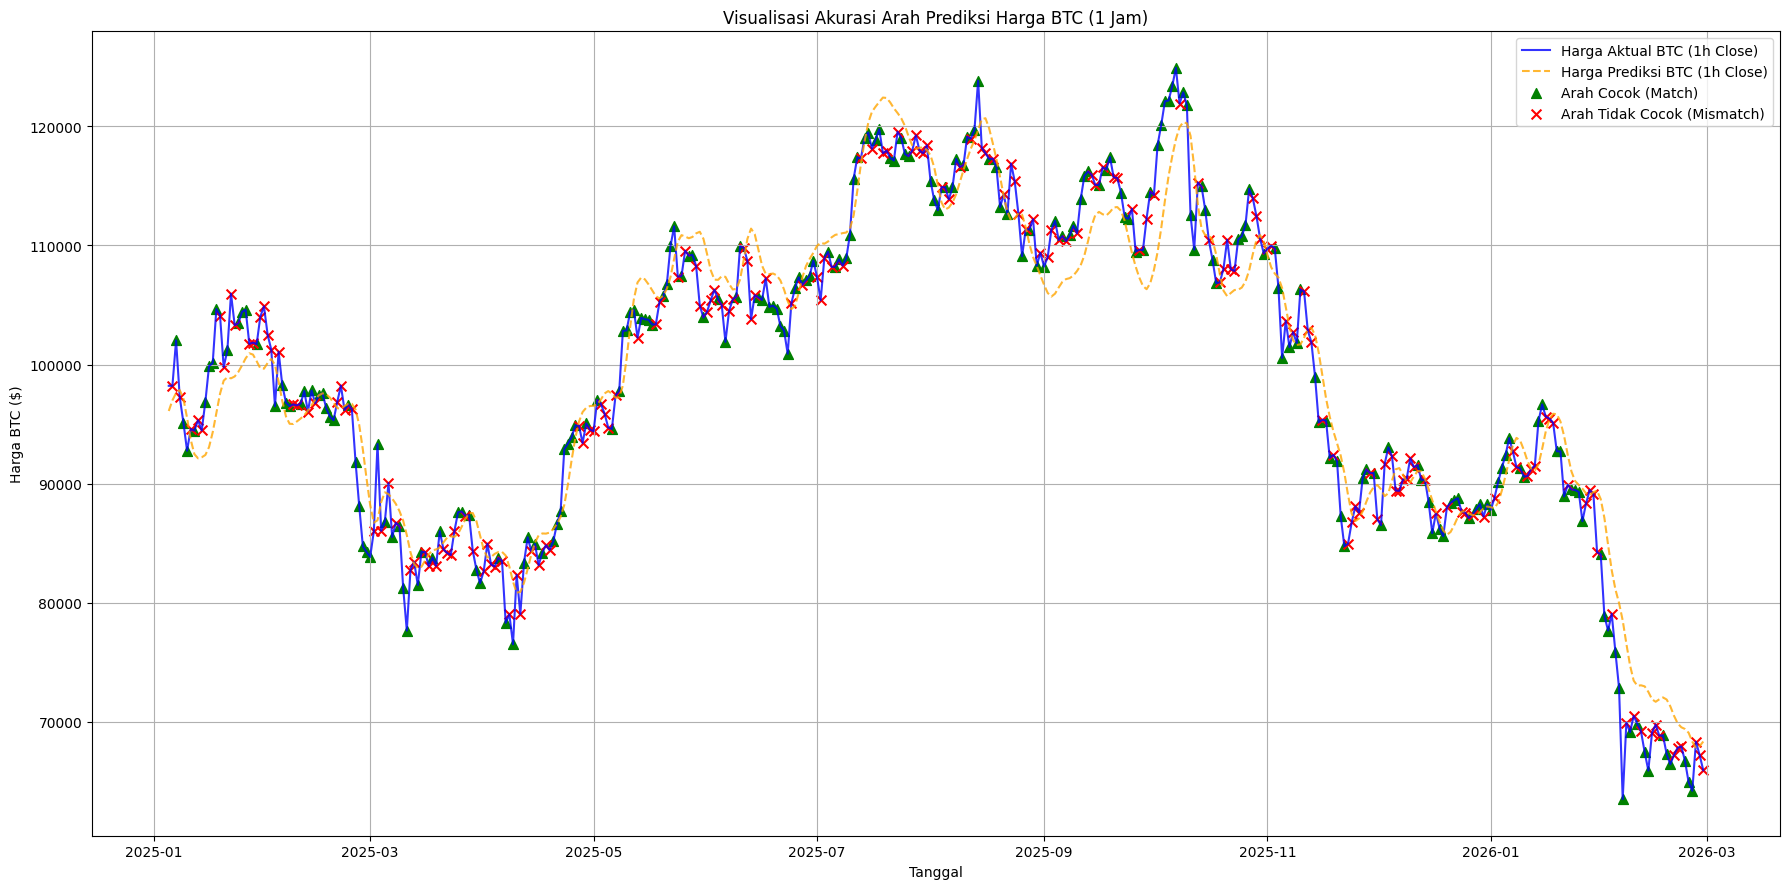

Visualisasi akurasi arah pergerakan harga selesai.


In [41]:
print("Memvisualisasikan akurasi arah pergerakan harga...")

# Ensure lstm_strategy_data is available and has the necessary columns
if 'lstm_strategy_data' not in globals() or lstm_strategy_data.empty:
    raise ValueError("DataFrame 'lstm_strategy_data' tidak ditemukan atau kosong. Pastikan sel 'Mendefinisikan aturan trading berbasis prediksi LSTM...' dan perhitungan akurasi arah telah dijalankan.")

if not all(col in lstm_strategy_data.columns for col in ['Actual_Price', 'Predicted_Price', 'Direction_Match', 'Actual_Direction']):
    raise ValueError("Kolom yang diperlukan ('Actual_Price', 'Predicted_Price', 'Direction_Match', 'Actual_Direction') tidak ditemukan di 'lstm_strategy_data'. Pastikan perhitungan akurasi arah telah berhasil.")

plt.figure(figsize=(18, 9))
plt.plot(lstm_strategy_data['Actual_Price'], label='Harga Aktual BTC (1h Close)', alpha=0.8, color='blue')
plt.plot(lstm_strategy_data['Predicted_Price'], label='Harga Prediksi BTC (1h Close)', alpha=0.8, linestyle='--', color='orange')

# Filter for matches and mismatches, ignoring the first NaN row from pct_change
# Use common_index from the previous cell or derive it again if needed.
# We will use the common_index derived in cell 9c35a27b.

# Filter based on Direction_Match column already present in lstm_strategy_data
matches_data = lstm_strategy_data[lstm_strategy_data['Direction_Match'] == 1].dropna(subset=['Actual_Direction'])
mismatches_data = lstm_strategy_data[lstm_strategy_data['Direction_Match'] == 0].dropna(subset=['Actual_Direction'])

# Plot directional matches
plt.scatter(
    matches_data.index,
    matches_data['Actual_Price'],
    marker='^',
    color='green',
    s=50,
    label='Arah Cocok (Match)'
)

# Plot directional mismatches
plt.scatter(
    mismatches_data.index,
    mismatches_data['Actual_Price'],
    marker='x',
    color='red',
    s=50,
    label='Arah Tidak Cocok (Mismatch)'
)

plt.title('Visualisasi Akurasi Arah Prediksi Harga BTC (1 Jam)')
plt.xlabel('Tanggal')
plt.ylabel('Harga BTC ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Visualisasi akurasi arah pergerakan harga selesai.")

In [42]:
# ==========================================================
# @title Prediksi Harga BTC_1h_Close untuk Periode N-Langkah ke Depan
# ==========================================================

print("Membuat prediksi harga BTC_1h_Close untuk periode N-langkah ke depan...")

# Memuat model terbaik yang telah disimpan
from tensorflow.keras.models import load_model
model = load_model('best_model.keras') # Pastikan model sudah dimuat

# --- Input Jumlah Langkah Prediksi --- #
# Anda bisa mengubah nilai ini sesuai dengan berapa jam ke depan yang ingin diprediksi
num_future_steps = 24 # Contoh: memprediksi 24 jam ke depan
print(f"Akan memprediksi harga untuk {num_future_steps} periode ke depan.")

# 1. Ambil urutan data terakhir dari X_test sebagai input awal
# Ini adalah 'window_len' data terakhir yang digunakan model untuk validasi.
current_input_sequence = X_test[-1].copy() # Buat salinan agar tidak mengubah X_test asli

# Simpan prediksi masa depan
future_predictions_scaled = []

# Dapatkan indeks kolom target 'BTC_1h_Close' dari feature_cols
feature_cols = data.select_dtypes(include=np.number).columns.tolist()
btc_close_idx = feature_cols.index('BTC_1h_Close')

# --- Loop untuk ramalan multi-langkah --- #
for _ in range(num_future_steps):
    # Reshape untuk input model: (1 sampel, window_len, features)
    # model.predict() mengharapkan input dengan dimensi batch.
    input_for_prediction = current_input_sequence.reshape(1, window_len, current_input_sequence.shape[1])

    # Lakukan prediksi
    predicted_scaled_value = model.predict(input_for_prediction, verbose=0)[0][0]
    future_predictions_scaled.append(predicted_scaled_value)

    # --- Konstruksi urutan input berikutnya untuk prediksi langkah selanjutnya ---
    # Hapus timestep tertua dari urutan input
    new_input_sequence = np.delete(current_input_sequence, 0, axis=0)

    # Buat timestep baru dengan prediksi baru
    # Asumsi: Untuk fitur lain selain BTC_1h_Close, gunakan nilai dari timestep terakhir yang diketahui.
    # Ini adalah penyederhanaan yang penting.
    last_known_timestep_features = current_input_sequence[-1].copy()
    last_known_timestep_features[btc_close_idx] = predicted_scaled_value

    # Tambahkan timestep baru ke urutan input
    current_input_sequence = np.vstack([new_input_sequence, last_known_timestep_features])

# 3. Diskalakan kembali prediksi ke rentang harga asli
future_predictions_descaled = []
for scaled_val in future_predictions_scaled:
    dummy_array = np.zeros((1, len(feature_cols)))
    dummy_array[0, btc_close_idx] = scaled_val
    descaled_val = scaler_data_frame.inverse_transform(dummy_array)[0, btc_close_idx]
    future_predictions_descaled.append(descaled_val)

# Mendapatkan tanggal dan jam untuk prediksi t+1, t+2, ..., t+N
last_actual_date = lstm_strategy_data.index[-1] # Tanggal terakhir dari data yang sudah dievaluasi
future_dates = [last_actual_date + pd.Timedelta(hours=i+1) for i in range(num_future_steps)]

print(f"\nHarga Aktual BTC_1h_Close terakhir ({last_actual_date}): {y_test_descaled[-1]:.2f}")
print("\nPrediksi Harga BTC_1h_Close untuk periode N-langkah ke depan:")
for date, pred_price in zip(future_dates, future_predictions_descaled):
    print(f"  {date}: {pred_price:.2f}")

print("\nRamalan N-langkah ke depan selesai.")

Membuat prediksi harga BTC_1h_Close untuk periode N-langkah ke depan...
Akan memprediksi harga untuk 24 periode ke depan.

Harga Aktual BTC_1h_Close terakhir (2026-02-28 00:00:00): 65942.10

Prediksi Harga BTC_1h_Close untuk periode N-langkah ke depan:
  2026-02-28 01:00:00: 68357.38
  2026-02-28 02:00:00: 68498.53
  2026-02-28 03:00:00: 68264.28
  2026-02-28 04:00:00: 67853.84
  2026-02-28 05:00:00: 67392.75
  2026-02-28 06:00:00: 67051.34
  2026-02-28 07:00:00: 66826.63
  2026-02-28 08:00:00: 66663.63
  2026-02-28 09:00:00: 66513.46
  2026-02-28 10:00:00: 66362.25
  2026-02-28 11:00:00: 66222.57
  2026-02-28 12:00:00: 66100.46
  2026-02-28 13:00:00: 66011.98
  2026-02-28 14:00:00: 65950.78
  2026-02-28 15:00:00: 65905.55
  2026-02-28 16:00:00: 65871.53
  2026-02-28 17:00:00: 65841.27
  2026-02-28 18:00:00: 65807.71
  2026-02-28 19:00:00: 65774.58
  2026-02-28 20:00:00: 65750.16
  2026-02-28 21:00:00: 65738.83
  2026-02-28 22:00:00: 65735.11
  2026-02-28 23:00:00: 65729.98
  2026-03-0